In [21]:
# This is the template for the submission. If you want, you can develop your algorithm in a regular Python script and copy the code here for submission.

# Team members (e-mail, legi):
# zhisun@ethz.ch, 22-958-227
# enjcao@ethz.ch, 22-942-700
# yifzhou@ethz.ch, 22-940-381

In [1]:
!pip3 install pybaselines

In [2]:
import pandas as pd
import math
from Lilygo.Recording import Recording
from Lilygo.Dataset import Dataset
from os import listdir
from os.path import isfile, join
from math import sqrt
import numpy as np
import scipy as sp
from scipy import signal
import matplotlib.pyplot as plt
import pybaselines

In [3]:
# Get the path of all traces
dir_traces = './data/traces'
filenames = [join(dir_traces, f) for f in listdir(dir_traces) if isfile(join(dir_traces, f))]
filenames.sort()
print(filenames)

['./data/traces/trace_01.json', './data/traces/trace_02.json', './data/traces/trace_03.json', './data/traces/trace_04.json', './data/traces/trace_05.json', './data/traces/trace_06.json', './data/traces/trace_07.json', './data/traces/trace_08.json', './data/traces/trace_09.json', './data/traces/trace_10.json']


In [108]:
# get minimum height for peak
def get_peak_height(input_signal):
    
    height = 0
    return height

In [7]:
def get_peaks(input_signal, min_peak_height):
    peak_locations, _ = sp.signal.find_peaks(input_signal, height=min_peak_height)
    peak_values = input_signal[peak_locations]
    valley_locations = sp.signal.find_peaks(-input_signal, height=min_peak_height)
    valley_values = input_signal[valley_locations]
    
    return peak_locations, peak_values

In [6]:
# Remove outliers
# Z score
def get_outliers(input_signal, z_threshold, timestamps, min_peak_height):
    # return arrays 'outlier_locations','outlier_values' with the same size as 'peaks_locations'/'peaks_values', 
    # The values and locations of oulier peaks in 'peaks_locations'/'peaks_values' are kept 
    # And those of non-oulier peaks are set to 0
    
    peak_locations, peak_values = get_peaks(input_signal, min_peak_height)
#     valley_locations, minus_valley_values = get_peaks(-input_signal, min_peak_height)

    z = np.abs(sp.stats.zscore(input_signal))
    compare = np.zeros_like(timestamps)
    for i in range(len(z)):   
        if z[i] > z_threshold:
            compare[i] = 1
    # compare: an array with 0 or 1 for found peak in denoised data, where 1 represents peak outliers at corresponding index
    
    outlier_locations = np.multiply(timestamps, compare)
    outlier_values = np.multiply(input_signal, compare)
#     print('compare:',compare,'\n outlier locations:',outlier_locations,'\n peak locations:',peak_locations,'\n outlier values:',outlier_values,'\n peak values:',peak_values)
    return outlier_locations,outlier_values

In [16]:
def baseline_corr(input_signal, sampling_rate):
    # add high pass filter
    filter_order = 1
    high_pass_cutoff_freq = 5; #2
    sos = signal.butter(filter_order, high_pass_cutoff_freq, 'highpass', fs=sampling_rate, output='sos')
    signal_highpass_filter = signal.sosfilt(sos, input_signal)
    baseline, _ = pybaselines.classification.fabc(input_signal, lam=1000000)
    mag_aligned = input_signal - baseline
    return baseline, mag_aligned

In [63]:
def baseline_corr_sec(input_signal, sampling_rate):
    # add high pass filter
    filter_order = 1
    high_pass_cutoff_freq = 5 # TODO: 
    sos = signal.butter(filter_order, high_pass_cutoff_freq, 'highpass', fs=sampling_rate, output='sos')
    signal_highpass_filter = signal.sosfilt(sos, input_signal)
    # seperate signal by second, add baseline correction
    seperate_len = 1000
    baseline = []
    wins = math.floor(len(input_signal)/seperate_len)
    for i in range(wins):
        signal_win = input_signal[i*seperate_len:i*seperate_len+seperate_len]
        baseline_win, _ = pybaselines.classification.fabc(signal_win, lam=5000000)
        baseline = np.hstack((baseline, baseline_win))
    # deal with last 500 data
    signal_win = input_signal[-seperate_len:]
    baseline_win, _ = pybaselines.classification.fabc(signal_win, lam=5000000)
    baseline = np.hstack((baseline[:(len(input_signal)-seperate_len)], baseline_win))
    
    baseline_baseline, _ = pybaselines.classification.fabc(baseline, lam=5000000)
    mag_aligned = input_signal - baseline_baseline
    return baseline_baseline, mag_aligned

In [4]:
def baseline_err_medfilter(input_signal, sampling_rate):
    baseline_medfilter = signal.medfilt(input_signal, 301)
    mag_aligned = input_signal - baseline_medfilter
    return baseline_medfilter, mag_aligned


In [5]:
def normalize(signal, min_peak_height):#, z_threshold, valley_values):
    # Find maximum among all peak values except outlier peaks
    peak_locations, peak_values = get_peaks(signal, min_peak_height)
    # outlier_locations, outlier_values = get_outliers(signal, z_threshold)
    max_candidates = peak_values #-outlier_values
    mx = np.max(max_candidates)
    
    # Find minimum all valley values except outlier valleys
    valley_locations, valley_values = get_peaks(-signal, min_peak_height)
    # voutlier_locations, voutlier_values = get_outliers(-signal, z_threshold)
    min_candidates = valley_values #-voutlier_values
    mn = -np.min(min_candidates)
    
    #normalize signal 
    normalized_signal = np.true_divide((signal-mn), (mx-mn), out=np.zeros_like(signal), where=(mx-mn)!=0)
    
    return normalized_signal

In [119]:
stepCounts = []
ids = []

# for filename in filenames:
filename = filenames[7]
trace = Recording(filename, no_labels=True, mute=True)
stepCount = 0

# Your algorithm goes here
# Make sure, you only use data from the LilyGo Wristband, namely the following 10 keys (as in trace.data[key]):
# 3-axis accelerometer: key in [ax, ay, az]
# 3-axis gyro: key in [gx, gy, gz]
# 3-axis magnetometer: key in [mx, my, mz]
# IMU temperature: key==temperature
trace = Recording(filename, no_labels=True, mute=True)
ax = trace.data['ax']
ay = trace.data['ay']
az = trace.data['az']
timestamp_raw = ax.timestamps
timestamp_ms = timestamp_raw*1000
sampling_rate = len(timestamp_raw)/timestamp_raw[-1]

# Trace must contain lilygo accelerometer data
assert('ax' in trace.data and 'ay' in trace.data and 'az' in trace.data)
# And those traces must be of the same length
assert(len(ax.values) == len(ay.values)  and len(ax.values) == len(az.values) )
# Calculate raw magnitude of accelerometer signal
amagn = [sqrt(a**2+ay.values[i]**2+az.values[i]**2)for i, a in enumerate(ax.values)]
trace.data['amagn'] = Dataset.fromLists('Accelerometer magnitude', amagn, timestamp_ms)

# Detrend the signal
mag_detrended = sp.signal.detrend(amagn)
trace.data['amagn_detrended'] = Dataset.fromLists('Detrended Accelerometer magnitude', mag_detrended, trace.data['ax'].timestamps)

In [126]:
# Smoothing the signal -----------------------------------------------------------------------------------
# Denoise with convolution
filter_window_size = 35
mag_denoise = np.convolve(mag_detrended, np.ones((filter_window_size,))/filter_window_size, mode='valid')

# Find outliers

# Baseline correction
baseline, mag_aligned = baseline_corr(mag_denoise, sampling_rate)

# Normalization
mag_norm = normalize(mag_aligned, min_peak_height=0)

In [ ]:
# Find outliers
z_threshold = 1
z,outlier_locations,outlier_values, peak_locations, peak_values = get_outliers(mag_denoise,z_threshold,timestamp_ms, 0)
print(z)

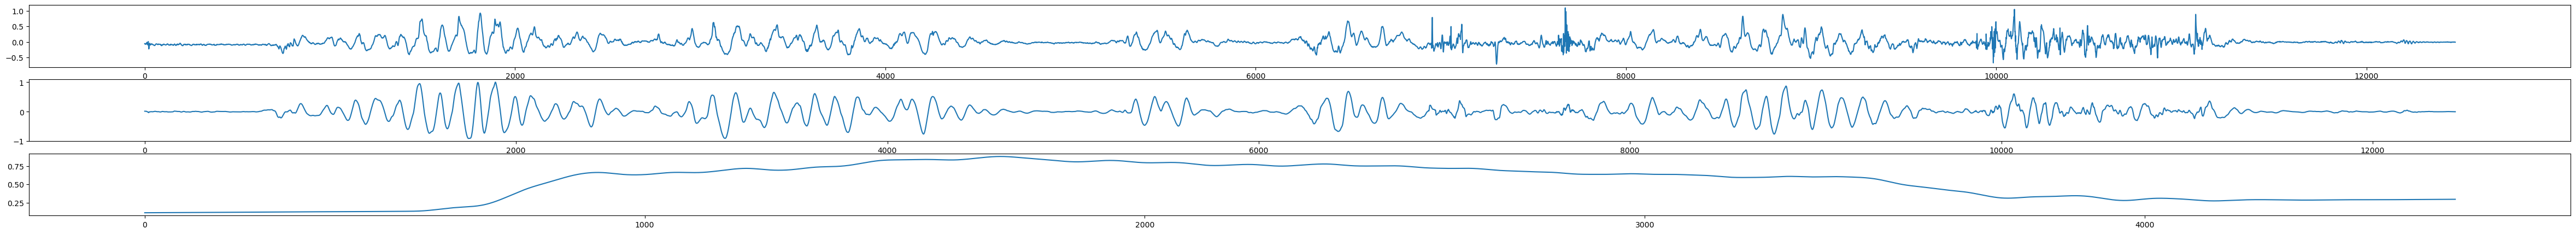

In [128]:
# Plot zone ----------------------------------------------------------------------------------------
# The original signal (Detrended)
fig, axes = plt.subplots(3,1, figsize=(60, 5)) #figsize is width, height
axes[0].plot(mag_detrended, alpha=1, label="Raw mag")

# The worked signal
# axes[1].plot(mag_denoise, alpha=1, label="smoothed")
axes[1].plot(mag_norm, alpha=1, label="smoothed")
axes[2].plot(baseline, alpha=1, label="smoothed")

# The marks
# axes[1].plot(peak_locations, peak_values, '+', color="yellow", label="Peak Locations")
# axes[1].plot(outlier_locations, outlier_values, '+', color="red", label="Peak Locations")

/var/folders/zf/6vgqjplx04s3k3bdvj13s5bc0000gn/T/ipykernel_87221/1070207853.py:73: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "y+" (-> color='y'). The keyword argument will take precedence.
  axes1[1].plot(peak_locations, mag_norm[peak_locations], 'y+', color="red", label="Peak Locations")


133
148
173
104
165
126
147
49
138
97


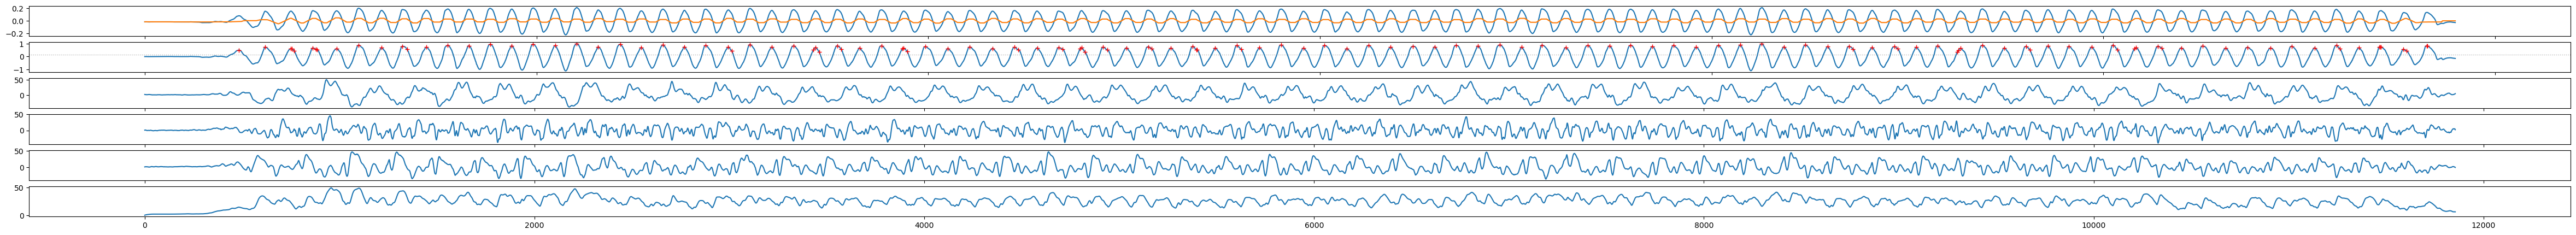

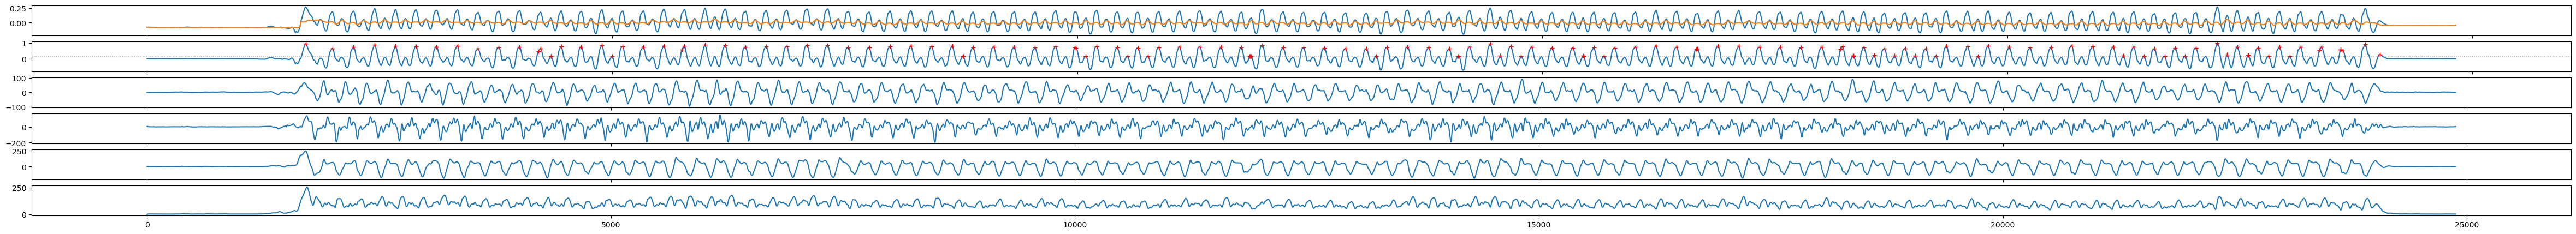

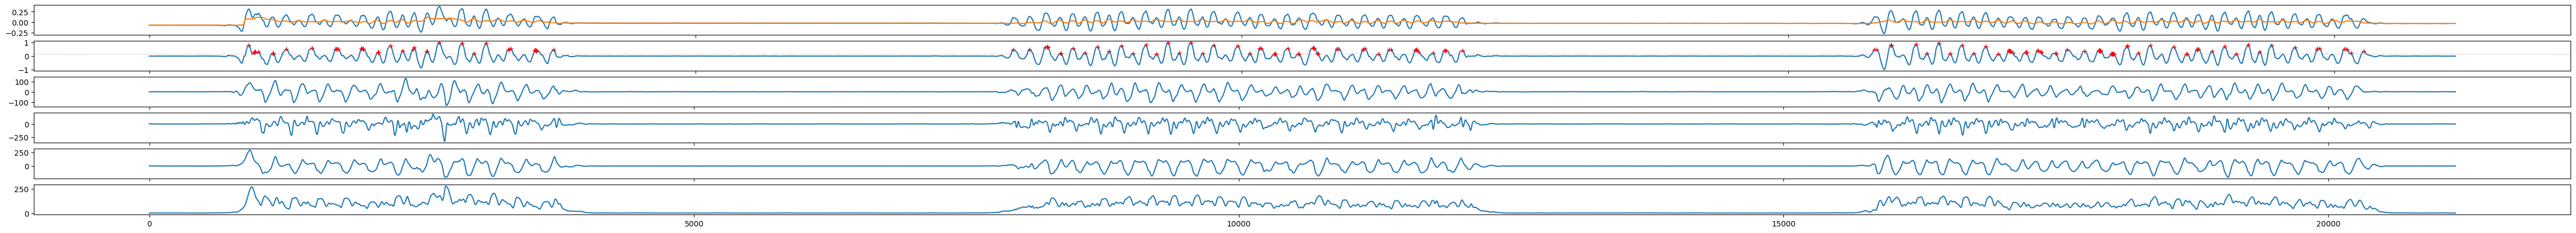

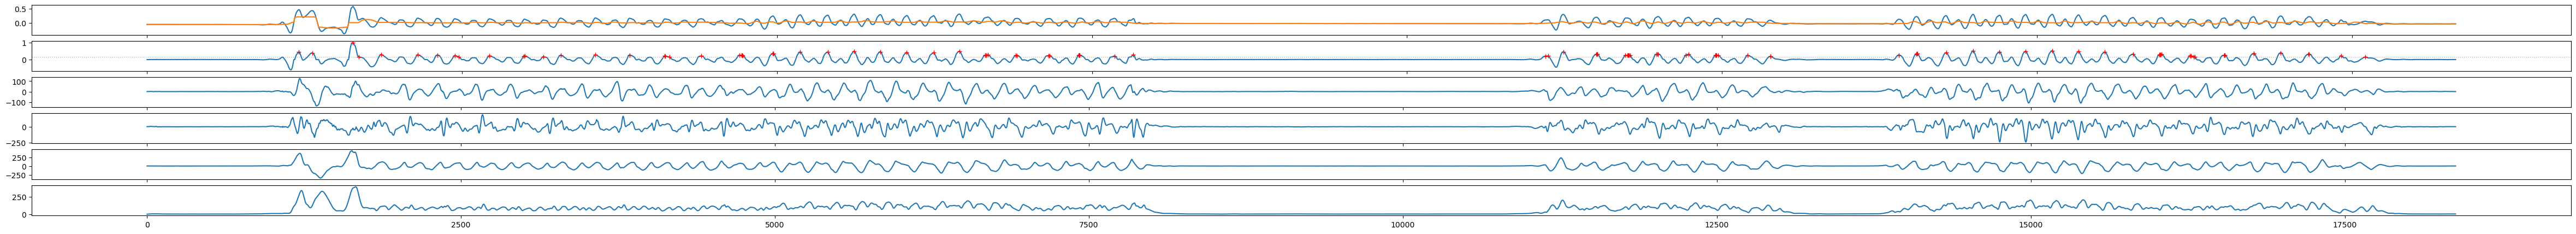

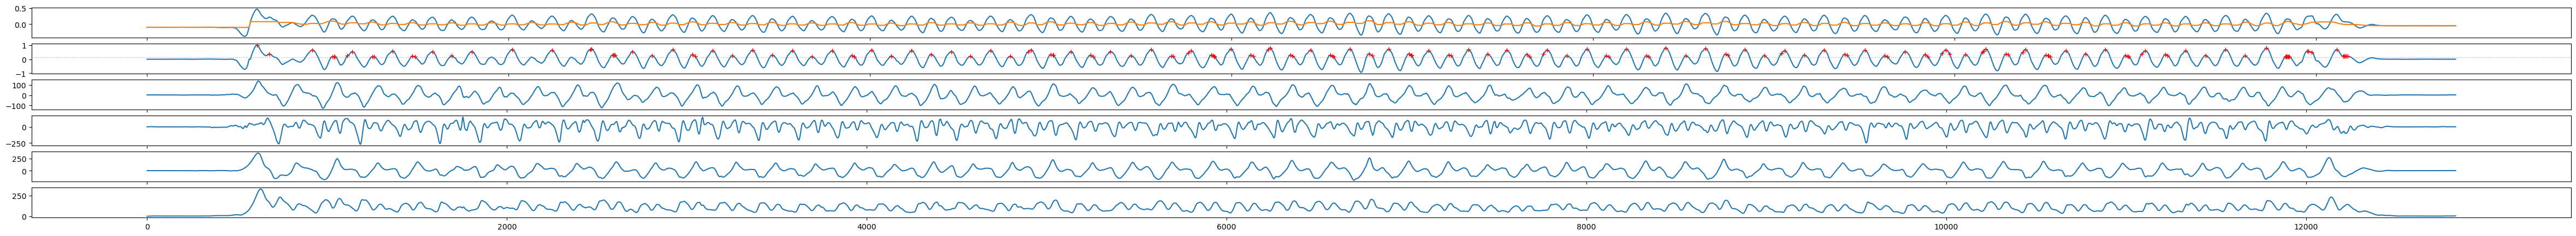

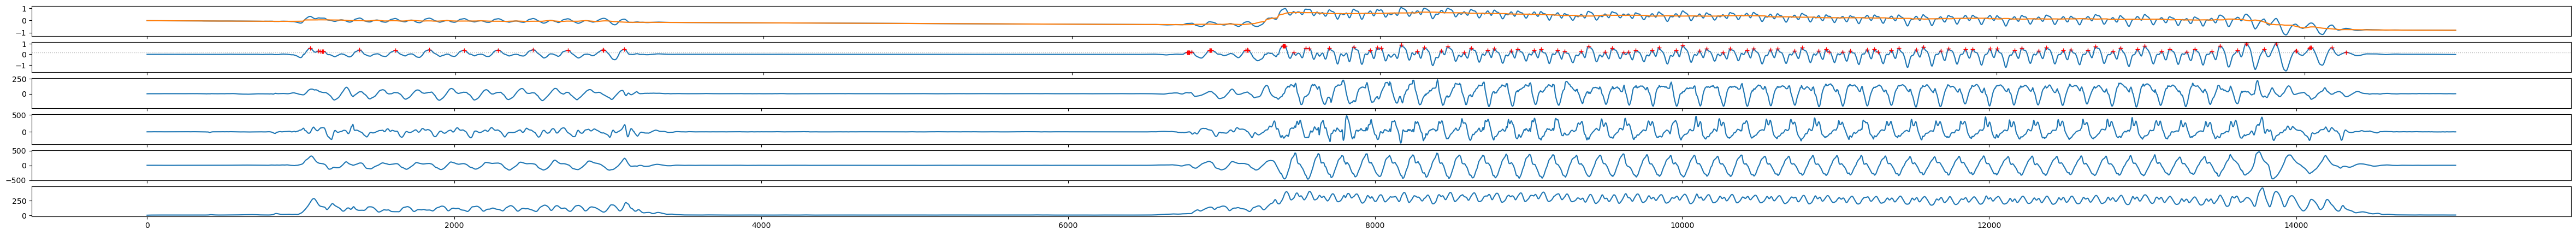

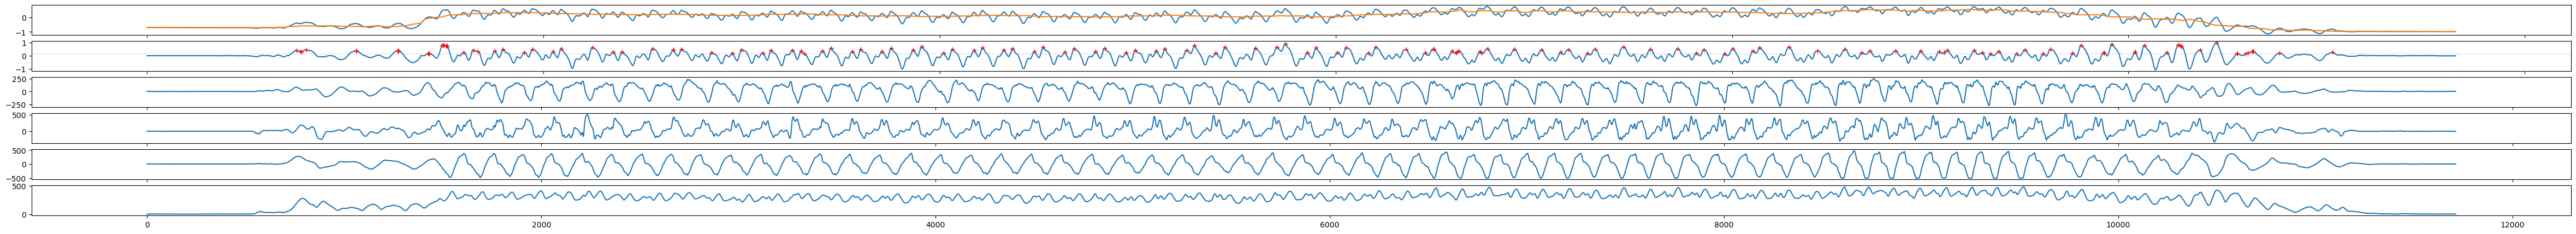

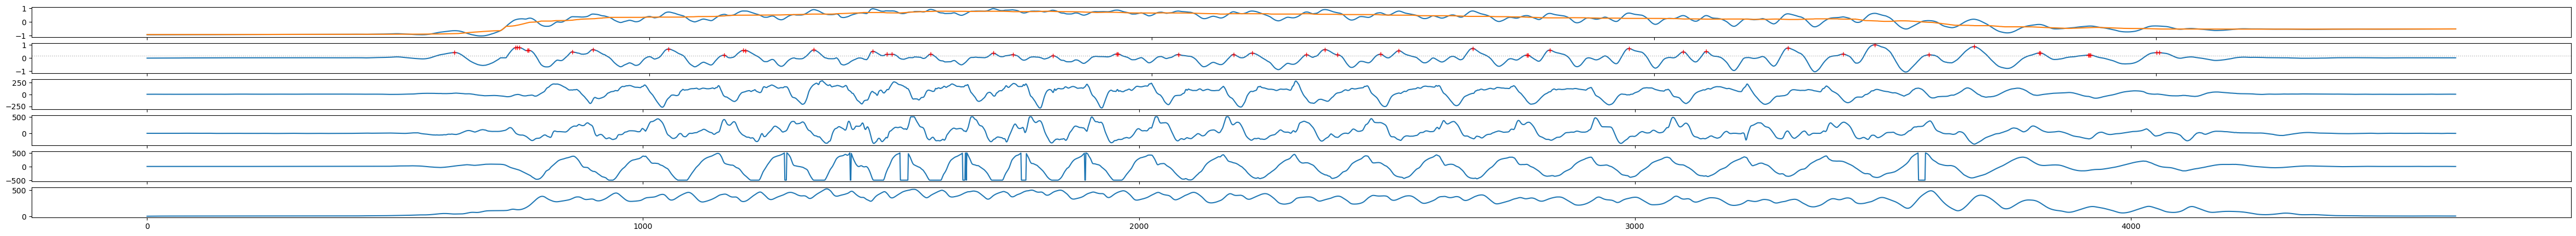

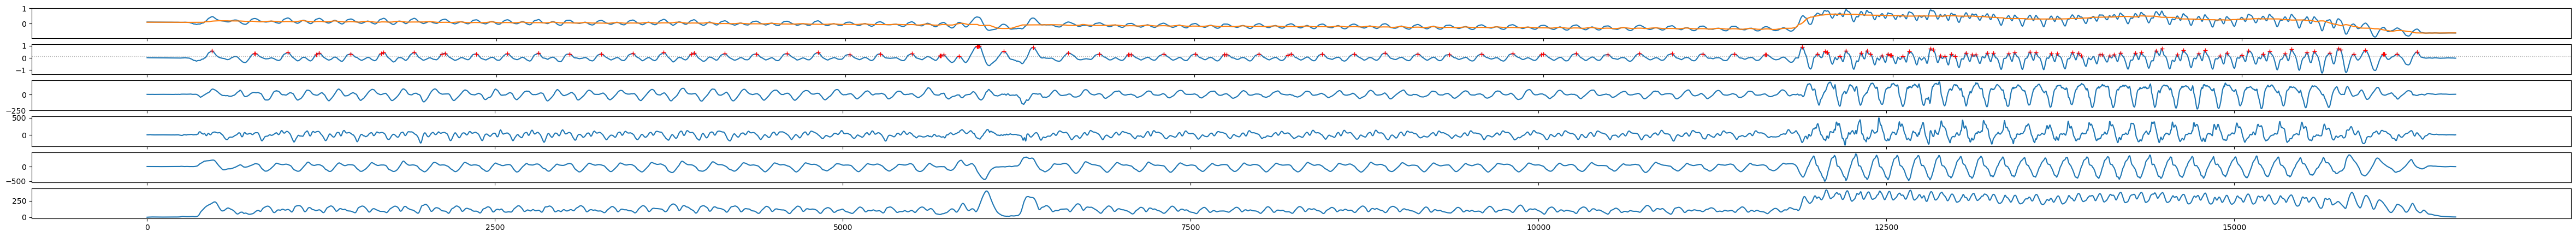

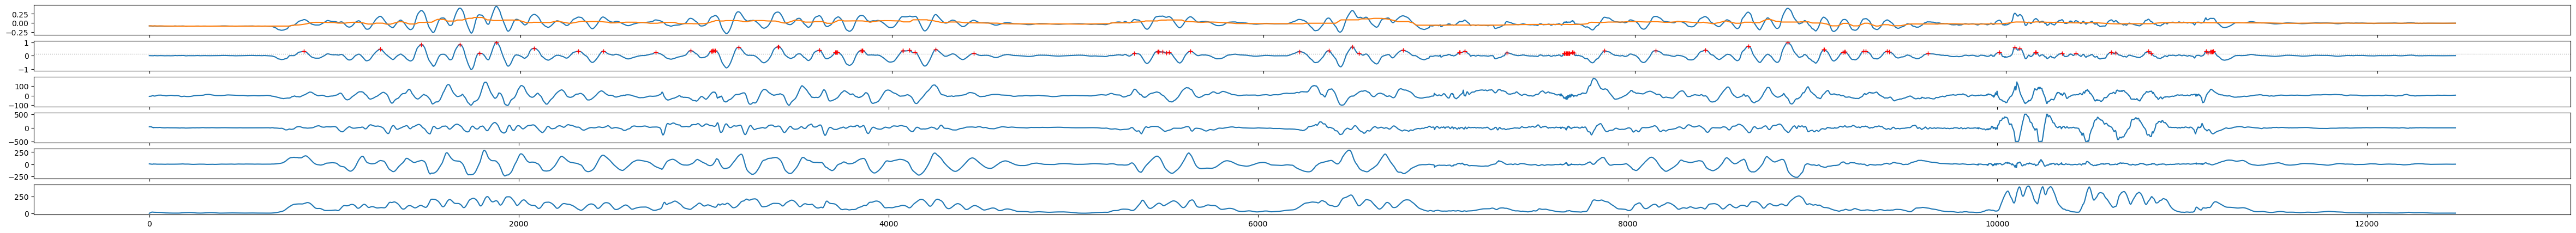

In [15]:
stepCounts = []
ids = []

for filename in filenames:
# filename = filenames[6]
    trace = Recording(filename, no_labels=True, mute=True)
    stepCount = 0

    # Your algorithm goes here
    # Make sure, you only use data from the LilyGo Wristband, namely the following 10 keys (as in trace.data[key]):
    # 3-axis accelerometer: key in [ax, ay, az]
    # 3-axis gyro: key in [gx, gy, gz]
    # 3-axis magnetometer: key in [mx, my, mz]
    # IMU temperature: key==temperature
    trace = Recording(filename, no_labels=True, mute=True)
    ax = trace.data['ax']
    ay = trace.data['ay']
    az = trace.data['az']

    gx = trace.data['gx']
    gy = trace.data['gy']
    gz = trace.data['gz']

    timestamp_raw = ax.timestamps
    timestamp_ms = timestamp_raw*1000
    sampling_rate = len(timestamp_raw)/timestamp_raw[-1]

    # Calculate raw magnitude of accelerometer signal
    amagn = [sqrt(a**2+ay.values[i]**2+az.values[i]**2)for i, a in enumerate(ax.values)]
    trace.data['amagn'] = Dataset.fromLists('Accelerometer magnitude', amagn, timestamp_ms)

    # Calculate raw magnitude of accelerometer signal
    gmagn = [sqrt(g**2+gy.values[i]**2+gz.values[i]**2)for i, g in enumerate(gx.values)]
    trace.data['gmagn'] = Dataset.fromLists('Accelerometer magnitude', gmagn, timestamp_ms)


    sos = signal.butter(1, 1.5, 'lowpass', fs=sampling_rate, output='sos')
    gmagn_lowpass_filter = signal.sosfilt(sos, gmagn)

 

    # Detrend the signal
    mag_detrended = sp.signal.detrend(amagn)
    trace.data['amagn_detrended'] = Dataset.fromLists('Detrended Accelerometer magnitude', mag_detrended, trace.data['ax'].timestamps)

    # Smoothing the signal -----------------------------------------------------------------------------------
    # Denoise with convolution
    filter_window_size = 60
    mag_denoise = np.convolve(mag_detrended, np.ones((filter_window_size,))/filter_window_size, mode='valid')

    # Find outliers

    # Baseline correction
    baseline, mag_aligned = baseline_err_medfilter(mag_denoise, sampling_rate)

    # Normalization
    mag_norm = normalize(mag_aligned, min_peak_height=0)




    min_peak_height = 0.15
    peak_locations, _ = get_peaks(mag_norm, min_peak_height)

    # print detected peak

    fig, axes1 = plt.subplots(6,1, figsize=(60, 5)) #figsize is width, height
    axes1[0].plot(mag_denoise, alpha=1, label="original")
    axes1[0].plot(baseline, alpha=1, label="baseline")

    axes1[1].plot(mag_norm, alpha=1, label="Filtered mag")
    axes1[1].axhline(y=min_peak_height, linewidth=1, linestyle=":", alpha=0.6, color='gray')
    axes1[1].plot(peak_locations, mag_norm[peak_locations], 'y+', color="red", label="Peak Locations")

    # plot gyroscope 
    axes1[2].plot(gx.values, alpha=1, label="gx")
    axes1[3].plot(gy.values, alpha=1, label="gy")
    axes1[4].plot(gz.values, alpha=1, label="gz")
    axes1[5].plot(gmagn_lowpass_filter, alpha=1, label="gz")

    stepCount = len(peak_locations)
    print(stepCount)

    # Append your calculated step counts and the id of the trace to the corresponding array
    stepCounts.append(stepCount)
    ids.append(filename.split('_')[1][:2])

In [ ]:
# Write the detected step counts into a .csv file to then upload the .csv file to Kaggle
# When cross-checking the .csv file on your computer, we recommend using the text editor and NOT excel so that the results are displayed correctly
# IMPORTANT: Do NOT change the name of the columns ('Id' and 'Predicted') of the .csv file
df = pd.DataFrame({'Id':ids,'Predicted':stepCounts})
df.to_csv('/kaggle/working/submission.csv', index=False)